# Background 

This analysis delves into the textual feedback provided by paramedic crews, focusing on their perspectives and suggestions regarding various aspects of ambulance services. It encompasses their views on several topics, including:

- The ease of accessing GPs through non-public numbers
- The support services needed to avoid unnessary admissions to Emergency Departments (EDs)
- The likelihood of recommending OPAL+ to colleagues
- Their experiences with Patient Services on DoS
- The involvement of Senior Clinicians in on-scene discussions
- The choices for clinical support during incidents
- Ideas for reducing handover delays
- The usage of Same Day Emergency Care (SDEC) Services

In [1]:
#| output: false
#| echo: false
#| label: import-libraries
#| cache: true

import pandas as pd
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
import re, string

nltk.download(['punkt',
              'stopwords',
              'wordnet',
               'omw-1.4',
              'averaged_perceptron_tagger'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\siti.hassan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siti.hassan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\siti.hassan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\siti.hassan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\siti.hassan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
#| output: false
#| echo: false
#| label: set-working_directory
#| cache: true
os.chdir('//mlcsu-bi-fs/csugroupdata$/Commissioning Intelligence And Strategy/BSOLCCG/Reports/01_Adhoc/BSOL_1298_Paramedics_Feedback_Analysis')

In [5]:
#| output: false
#| echo: false
#| label: import-data
#| cache: true
data = pd.read_excel('Data\Feedback from Paramedics on the Road.xlsx')
theme = pd.read_excel('Data\SurveyTheme.xlsx')

subset = data.loc[:, ['How easy is it to access a GP via the Non-Public number?',
                     'What services do you need to support you with admission avoidance to ED?',
                     'How likely are you to recommend OPAL+ to a colleague?',
                     'Have you used Patient Services on DoS?',
                     'Do Senior Clinicians come out to the Ambulance to discuss your patient when delayed?',
                     'Who do you call for Clinical Support on scene?',
                     'What do you feel would improve handover delays?',
                    'Have you used SDEC Services?'
                     ]]

In [6]:
def remove_noise_and_lemmatize(tokens, stop_words=()):
    lemmatizer = WordNetLemmatizer()
    cleaned_tokens = []

    for token, tag in pos_tag(tokens):
        if token.lower() not in stop_words and token not in string.punctuation:
            pos = 'n' if tag.startswith('NN') else 'v' if tag.startswith('VB') else 'a'
            lemmatized_token = lemmatizer.lemmatize(token, pos)
            cleaned_tokens.append(lemmatized_token.lower())

    return cleaned_tokens

def clean_text(text):
    if not isinstance(text, str):
        text = ''
    
     # Create a translation table that maps apostrophes to None
    translator = str.maketrans('', '', "’")
    
    # Custom replacements for common contractions
    contractions_dict = {
        'don’t': 'dont', 'won’t': 'wont', 'can’t': 'cant',
        'isn’t': 'isnt', 'aren’t': 'arent', 'didn’t': 'didnt'
    }
    
    for contraction, replacement in contractions_dict.items():
        text = text.replace(contraction, replacement)
        
    # Remove apostrophes
    text = text.translate(translator)

    tokens = word_tokenize(text.lower())
    cleaned_tokens = remove_noise_and_lemmatize(tokens, set(stopwords.words('english')))

    return cleaned_tokens

def tokenize_responses(column):
    cleaned_responses = column.apply(clean_text)
    flat_list = [word for sublist in cleaned_responses for word in sublist]
    return pd.DataFrame(flat_list, columns=['Words'])

In [9]:
#| output: false
#| echo: false
#| cache: true

# Create DataFrames for Each Question
Q1_df = tokenize_responses(subset['How easy is it to access a GP via the Non-Public number?'])
Q2_df = tokenize_responses(subset['What services do you need to support you with admission avoidance to ED?'])
Q3_df = tokenize_responses(subset['How likely are you to recommend OPAL+ to a colleague?'])
Q4_df = tokenize_responses(subset['Have you used Patient Services on DoS?'])
Q5_df = tokenize_responses(subset['Do Senior Clinicians come out to the Ambulance to discuss your patient when delayed?'])
Q6_df = tokenize_responses(subset['Who do you call for Clinical Support on scene?'])
Q7_df = tokenize_responses(subset['What do you feel would improve handover delays?'])
Q8_df = tokenize_responses(subset['Have you used SDEC Services?'])

In [15]:
# Function to calculate word frequency
def word_frequency(data, column):
    word_counts = data[column].value_counts()
    word_counts_df = word_counts.reset_index()
    word_counts_df.columns = ['Word', 'Frequency']
    
    return word_counts_df

Q1_word_counts = word_frequency(Q1_df, 'Words')
Q2_word_counts = word_frequency(Q2_df, 'Words')
Q3_word_counts = word_frequency(Q3_df, 'Words')
Q4_word_counts = word_frequency(Q4_df, 'Words')
Q5_word_counts = word_frequency(Q5_df, 'Words')
Q6_word_counts = word_frequency(Q6_df, 'Words')
Q7_word_counts = word_frequency(Q7_df, 'Words')
Q8_word_counts = word_frequency(Q8_df, 'Words')

In [12]:
import plotly.graph_objects as go

def plot_word_frequency(word_counts_df, plot_width=800, plot_height=600):
    # Sort the DataFrame by frequency in descending order
    sorted_df = word_counts_df.sort_values(by='Frequency', ascending=False)

    # Create a horizontal bar chart
    fig = go.Figure([go.Bar(x=sorted_df['Frequency'], y=sorted_df['Word'], orientation='h')])

    # Add titles and labels
    fig.update_layout(
        title='Word Frequency Distribution',
        xaxis_title='Frequency',
        yaxis_title='Words',
        yaxis=dict(autorange="reversed"),  # To display highest frequencies at the top
        width=plot_width,  # Width of the plot
        height=plot_height  # Height of the plot
    )

    # Show the plot
    fig.show()


#2. Function to plot bar chart

import plotly.express as px

## Horizontal bar chart

def plot_bar_chart(data, column, title):
    
    value_counts = data[column].value_counts().reset_index()
    value_counts.columns = ['Responses', 'Frequency']
    sorted_df = value_counts.sort_values(by='Frequency', ascending=False)
    
    fig = px.bar(sorted_df, x='Frequency', y='Responses', title=title, text = "Frequency", color="Frequency",
    color_continuous_scale=px.colors.sequential.Viridis)
    fig.update_traces(textposition="outside", textangle=0, cliponaxis=False, textfont_size=8)
    fig.update_layout(
        yaxis={'categoryorder':'total ascending'},
        showlegend=False,
        coloraxis_showscale=False
        # width=800,  # Width of the plot
        #height=plot_height  # Height of the plot
    )
    fig.show()

## Vertical bar chart

def plot_bar_chart2(data, column, title):
    value_counts = data[column].value_counts().reset_index()
    value_counts.columns = ['Responses', 'Frequency']
    sorted_df = value_counts.sort_values(by='Frequency', ascending=False)

    fig = px.bar(sorted_df, x='Responses', y="Frequency", title=title,
                 text="Frequency", color="Frequency", color_continuous_scale=px.colors.sequential.Cividis_r)

    fig.update_traces(textposition="outside", textangle=0, cliponaxis=False, textfont_size=8)

    fig.update_layout(
        yaxis={'categoryorder': 'total ascending'},
        xaxis_tickangle=-45,
        showlegend=False,
        coloraxis_showscale=False,
        margin=dict(b=100) # Adjust bottom margin to ensure labels fit
        # width=800,  # Width of the plot
        # height=plot_height  # Height of the plot
    )
    fig.show()
    
#3. Function to plot word cloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(word_counts_data):
    
    # Create a dictionary where keys are words and values are their corresponding frequencies
    word_freq_dict = word_counts_data.set_index('Word')['Frequency'].to_dict()
    
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=600, background_color ='white')

    # Generate a word cloud
    wordcloud.generate_from_frequencies(word_freq_dict)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis numbers and labels
    plt.show()
    
#4. Function to plot treemap for bigrams
def plot_treemap(ngrams_function, tokenized_response_df, ngram_column):
    ngrams_df = ngrams_function(tokenized_response_df)
    
    # Convert each tuple in the 'n-gram' column to a string
    ngrams_df[ngram_column] = ngrams_df[ngram_column].apply(lambda x: ', '.join(x))
    
    total_freq = ngrams_df['Frequency'].sum()
    ngrams_df['Frequency'] = (ngrams_df['Frequency'] / total_freq) * 100
    modified_ngram = ngram_column.replace("gram", "-grams")

    # Plot using plotly
    fig = px.treemap(
        ngrams_df.head(20),  
        path=[ngram_column],
        values='Frequency',
        title=f"Top 20 {modified_ngram} by Frequency (%)",
        custom_data=[ngram_column, 'Frequency'] 
    )

    # Update hover template to show only bigrams and frequency
    fig.update_traces(
        hovertemplate='<b>%{customdata[0]}</b><br>Frequency: %{customdata[1]:.2f}%',
        textposition='middle center',  # Center the text inside the boxes
        textfont=dict(size=8)          # Set the text font size
    )

    fig.update_layout(
        uniformtext=dict(minsize=8, mode='hide'),
        coloraxis_showscale=False,
        height=600,
        width=1000
    )

    fig.show()

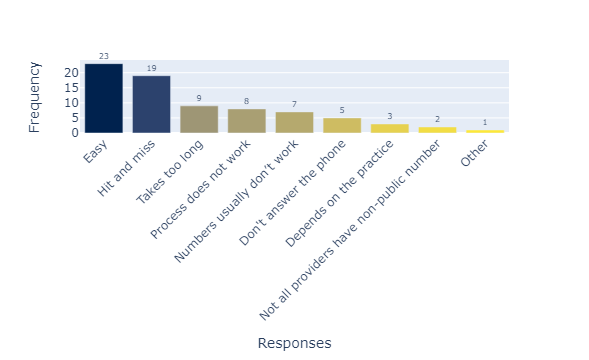

In [19]:
Q1_theme = pd.DataFrame(theme.iloc[:, 0].dropna())

plot_bar_chart2(Q1_theme, column = 'Q1.Theme', title = "" )

In [218]:


# Create a translation table that maps punctuation and the apostrophe to None
translator = str.maketrans('', '', string.punctuation + "'")

# Use the translator to remove punctuation and apostrophes from each word
large_list = [w.translate(translator) for w in Q1_df]

# Further clean the list by removing empty strings which may result from removing punctuation
large_list = [word for word in large_list if word]

large_list


['Words']

# Concordance and Collocations

In [244]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.collocations import TrigramCollocationFinder, TrigramAssocMeasures
from nltk.collocations import QuadgramCollocationFinder, QuadgramAssocMeasures


def find_bigrams(tokenized_df):
    words = tokenized_df['Words'].tolist()
    
    # Find bi-grams
    finder = BigramCollocationFinder.from_words(words)
    
    # Use Finder to find bi-grams
    scored = finder.score_ngrams(nltk.collocations.BigramAssocMeasures().raw_freq)
    
    # Sort the bi-grams by frequency
    sorted_bigrams = sorted(scored, key=lambda x: x[1], reverse=True)
    
    # Create a DataFrame
    bigrams_df = pd.DataFrame(sorted_bigrams, columns=['Bigram', 'Frequency'])
    
    return bigrams_df

def find_trigrams(tokenized_df):
    words = tokenized_df['Words'].tolist()
    
    # Find tri-grams
    finder = TrigramCollocationFinder.from_words(words)
    
    # Find trigrams based on frequency
    trigram_measures = TrigramAssocMeasures()
    scored_trigrams = trigram_finder.score_ngrams(trigram_measures.raw_freq)

    # Sorting trigrams
    sorted_trigrams = sorted(scored_trigrams, key=lambda x: x[1], reverse=False)

    # Create a DataFrame
    trigrams_df = pd.DataFrame(sorted_trigrams, columns=['Trigram', 'Frequency'])
    
    return trigrams_df
    
def find_quadgrams(tokenized_df):
    words = tokenized_df['Words'].tolist()
    
    # Find quadgrams
    quadgram_finder = QuadgramCollocationFinder.from_words(words)
    
    # Find quadgrams based on frequency
    quadgram_measures = QuadgramAssocMeasures()
    scored_quadgrams = quadgram_finder.score_ngrams(quadgram_measures.raw_freq)

    # Sorting quadgrams
    sorted_quadgrams = sorted(scored_quadgrams, key=lambda x: x[1], reverse=True)

    # Create a DataFrame for quadgrams
    quadgrams_df = pd.DataFrame(sorted_quadgrams, columns=['Quadgram', 'Frequency'])
    
    return quadgrams_df
    

In [253]:
find_bigrams(Q1_df)

Bigram  Frequency
0         (take, long)   0.032895
1         (easy, easy)   0.023026
2      (process, work)   0.019737
3         (work, easy)   0.016447
4    (easy, sometimes)   0.013158
..                 ...        ...
238     (work, really)   0.003289
239    (work, surgery)   0.003289
240       (work, time)   0.003289
241  (work, well.some)   0.003289
242           (‘, hit)   0.003289

[243 rows x 2 columns]

In [268]:

def plot_bubble_plot(ngrams_df, ngram_column):
    # Convert each tuple in the 'n-gram' column to a string
    ngrams_df[ngram_column] = ngrams_df[ngram_column].apply(lambda x: ','.join(x))
    ngrams_df['Frequency'] = ngrams_df['Frequency'].apply(lambda x: x*100)
    
    modified_ngram = ngram_column.replace("gram", "-gram")

    # Plot using plotly
    fig = px.scatter(
        ngrams_df.head(20),  # Adjust the number to display as needed
        x=ngram_column,
        y='Frequency',
        size='Frequency',
        size_max=60,  
        color = 'Frequency',
        color_continuous_scale=px.colors.sequential.Viridis,
        title=f"Top 20 {modified_ngram} by Frequency (%)",
        labels={f"{ngram_column}": f"{modified_ngram}", "Frequency": "Frequency (%)"}
)

    fig.update_traces(marker=dict(opacity=0.6))

    fig.update_layout(
        coloraxis_showscale=False,
        xaxis = dict(title = ""),
        yaxis = dict(title = ""),
        xaxis_tickangle=-45,
        height=600,
        width=800
)

    fig.show()



In [334]:
bigrams_df = find_bigrams(Q7_df)
total_freq = bigrams_df['Frequency'].sum()

bigrams_df['Frequency'] = (bigrams_df['Frequency'] / total_freq) * 100



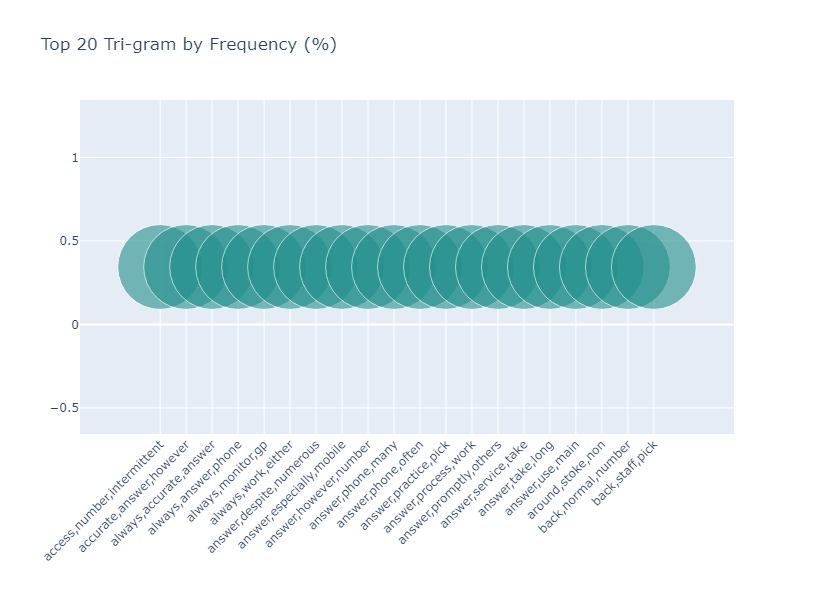

In [277]:

trigrams_df = find_trigrams(Q7_df)

plot_bubble_plot(trigrams_df, "Trigram")

In [333]:
def plot_bar_chart_ngrams(ngrams_df, ngram_column):
    # Convert each tuple in the 'n-gram' column to a string
    ngrams_df[ngram_column] = ngrams_df[ngram_column].apply(lambda x: ','.join(x))
    
    # Calculate total frequency for conversion to percentages
    total_freq = ngrams_df['Frequency'].sum()
    ngrams_df['Frequency'] = (ngrams_df['Frequency'] / total_freq) * 100  # Convert to percentage
    
    modified_ngram = ngram_column.replace("gram", "-gram")

    # Plot using plotly
    fig = px.bar(
        ngrams_df.head(20),  # Adjust the number to display as needed
        x=ngram_column,
        y='Frequency',
        color='Frequency',
        color_continuous_scale=px.colors.sequential.Cividis_r,
        title=f"Top 20 {modified_ngram} by Frequency (%)",
        labels={ngram_column: modified_ngram, "Frequency": "Frequency (%)"}
    )

    fig.update_layout(
        coloraxis_showscale=False,
        xaxis_tickangle=-45,
        xaxis=dict(title=modified_ngram),
        yaxis=dict(title='Frequency (%)'),
        height=600,
        width=800
    )

    fig.show()


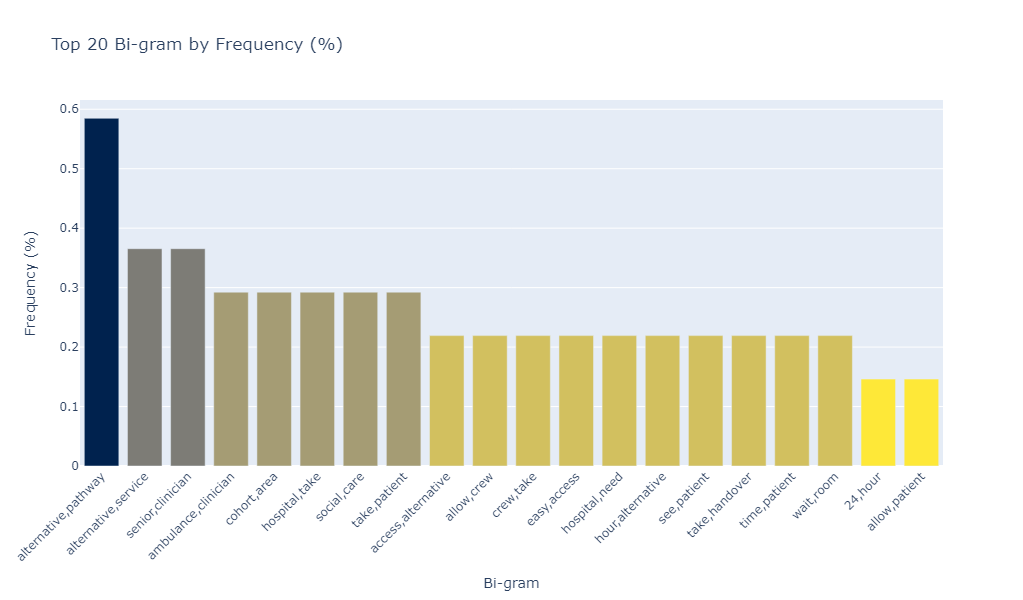

In [335]:

# bigrams_df.head()

plot_bar_chart_ngrams(bigrams_df, "Bigram")



In [361]:
def plot_treemap(ngrams_function, tokenized_response_df, ngram_column):
    
    ngrams_df = ngrams_function(tokenized_response_df)
    
    # Convert each tuple in the 'n-gram' column to a string
    ngrams_df[ngram_column] = ngrams_df[ngram_column].apply(lambda x: ', '.join(x))
    
    total_freq = ngrams_df['Frequency'].sum()

    ngrams_df['Frequency'] = (ngrams_df['Frequency'] / total_freq) * 100

    modified_ngram = ngram_column.replace("gram", "-gram")

    # Plot using plotly
    fig = px.treemap(
        ngrams_df.head(20),  
        path=[ngram_column],
        values='Frequency',
        title=f"Top 20 {modified_ngram} by Frequency (%)",
        # hover_data={ngram_column: True,
        #             'Frequency': ':.2f'} 
        custom_data=['Frequency'] 
    )
     # Update hover template to show only bigrams and frequency
    fig.update_traces(
        hovertemplate='<b>Frequency: %{customdata[0]:.2f}%'
    )
    fig.update_layout(
        coloraxis_showscale=False,
        height=600,  
        width=800   
    )

    fig.show()


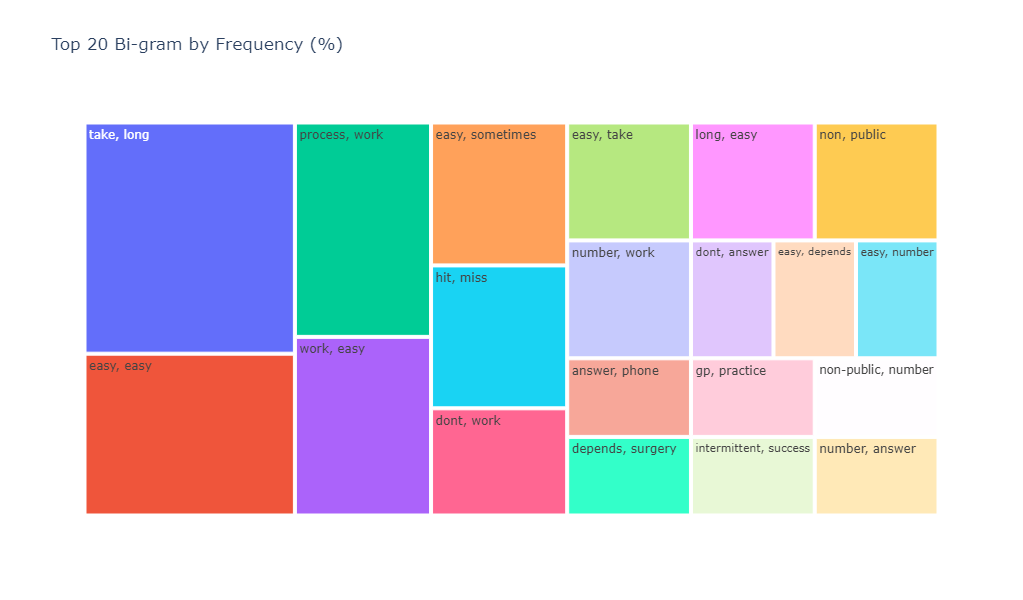

In [362]:
plot_treemap(ngrams_function = find_bigrams, tokenized_response_df = Q1_df,  ngram_column = "Bigram")

In [221]:
#| output: false
#| echo: false
#| label: word-frequency
#| cache: true

# Function to calculate word frequency
def word_frequency(data, column):
    word_counts = data[column].value_counts()
    word_counts_df = word_counts.reset_index()
    word_counts_df.columns = ['Word', 'Frequency']
    
    return word_counts_df

Q1_word_counts = word_frequency(Q1_df, 'Words')
Q2_word_counts = word_frequency(Q2_df, 'Words')
Q3_word_counts = word_frequency(Q3_df, 'Words')
Q4_word_counts = word_frequency(Q4_df, 'Words')
Q5_word_counts = word_frequency(Q5_df, 'Words')
Q6_word_counts = word_frequency(Q6_df, 'Words')
Q7_word_counts = word_frequency(Q7_df, 'Words')
Q8_word_counts = word_frequency(Q8_df, 'Words')

In [11]:
Q1_theme = pd.DataFrame(theme.iloc[:, 0].dropna())
Q1_theme

Unnamed: 0
1                                        Q1 Responses
2                                                Easy
3                                        Hit and miss
4                                      Takes too long
5                               Process does not work
6                          Numbers usually don’t work
7                              Don't answer the phone
8                             Depends on the practice
9            Not all providers have non-public number
10                                              Other
13                                       Q2 Responses
14       Improved Out-of-Hours and Overnight Services
15        More Specialised Services and Direct Access
16  Streamlined Referral Processes and Single Poin...
17                             Mental Health Services
18  Increased Acceptance of Referrals and Expanded...
19                      Community and Home-Based Care
20        Digital and Updated Directories of Services
21    Enhanced Skills and Capabilities for Paramedics
22         Funding and Resources for Bed Availability
23      Improved Accessibility to GPs and Call Triage
24    Improved Patient Education and Public Awareness
25                  Improved Clinical Decision Making
26  Improving Pre-Hospital Care and Discharge Proc...
27           Enhanced Support for Specific Conditions
28                 Enhanced Support for Social Issues
29                 Enhanced Support for Minor Illness
30                  Drop in Access to Walk-in Centres
31                  Enhanced Diagnostic Capabilities

In [13]:
#| output: false
#| echo: false
#| label: plot-word-frequency
#| cache: true

import plotly.graph_objects as go

def plot_word_frequency(word_counts_df, plot_width=800, plot_height=600):
    # Sort the DataFrame by frequency in descending order
    sorted_df = word_counts_df.sort_values(by='Frequency', ascending=False)

    # Create a horizontal bar chart
    fig = go.Figure([go.Bar(x=sorted_df['Frequency'], y=sorted_df['Word'], orientation='h')])

    # Add titles and labels
    fig.update_layout(
        title='Word Frequency Distribution',
        xaxis_title='Frequency',
        yaxis_title='Words',
        yaxis=dict(autorange="reversed"),  # To display highest frequencies at the top
        width=plot_width,  # Width of the plot
        height=plot_height  # Height of the plot
    )

    # Show the plot
    fig.show()


In [294]:
#| output: false
#| echo: false
#| label: plot-bar-chart
#| cache: true

import plotly.express as px

def plot_bar_chart(data, column, title, plot_width=800, plot_height=600):
    
    value_counts = data[column].value_counts().reset_index()
    value_counts.columns = ['Responses', 'Frequency']
    sorted_df = value_counts.sort_values(by='Frequency', ascending=False)
    
    fig = px.bar(sorted_df, x='Frequency', y='Responses', title=title, text_auto = True)
    fig.update_traces(textposition="outside", textangle=0, cliponaxis=False)
    fig.update_layout(
        yaxis={'categoryorder':'total ascending'},
        width=plot_width,  # Width of the plot
        height=plot_height  # Height of the plot
    )
    fig.show()
    
  

In [314]:
#| output: false
#| echo: false
#| label: plot-word-cloud
#| cache: true


from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Function to plot word cloud
def plot_wordcloud(word_counts_data):
    
    # Create a dictionary where keys are words and values are their corresponding frequencies
    word_freq_dict = word_counts_data.set_index('Word')['Frequency'].to_dict()
    
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color ='white')

    # Generate a word cloud
    wordcloud.generate_from_frequencies(word_freq_dict)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis numbers and labels
    plt.show()
    

# Q1: How easy is it to access a GP via the Non-Public number? 

## Column 

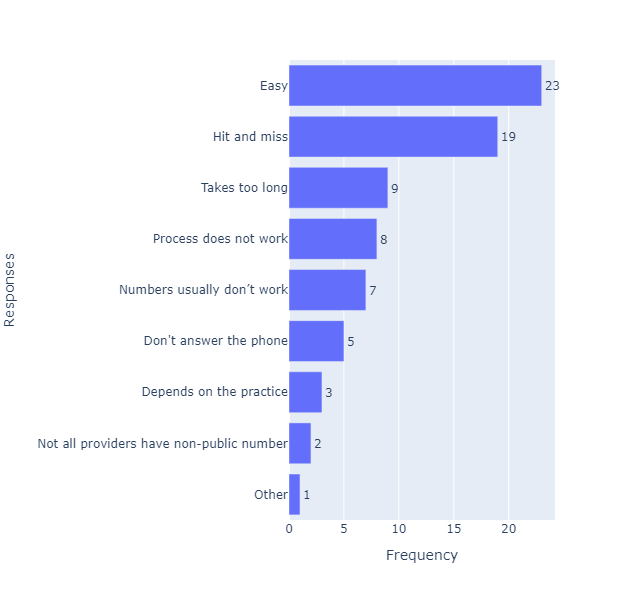

In [16]:
Q1_theme = pd.DataFrame(theme.iloc[:, 0].dropna())

plot_bar_chart(Q1_theme, column = 'Q1.Theme', title = "")

## Column 

In [3]:
plot_wordcloud(Q1_word_counts)

NameError: name 'Q1_word_counts' is not defined

# Q2: What services do you need to support you with admission avoidance to ED?

::: {.panel-tabset}

## Bar chart

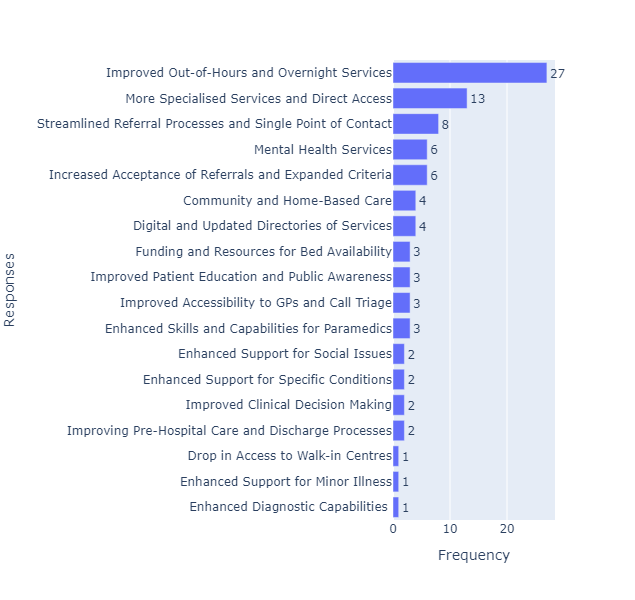

In [91]:
#| label: Q2-responses

Q2_theme = pd.DataFrame(theme.iloc[:, 1].dropna())

plot_bar_chart(Q2_theme, column = 'Q2.Theme', title = "")

## Word Cloud

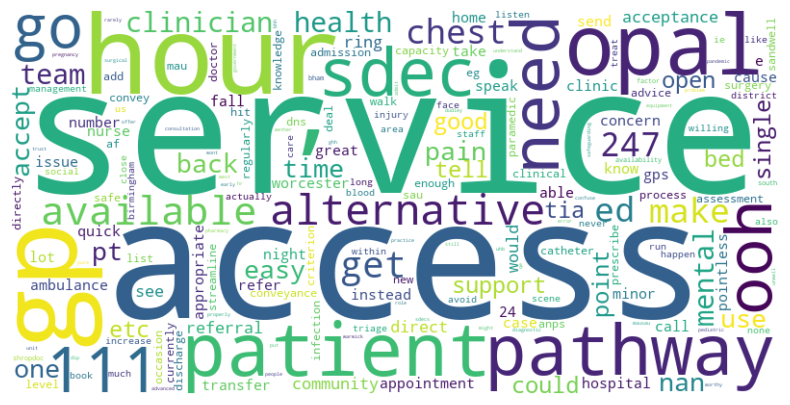

In [93]:
plot_wordcloud(Q2_word_counts)

:::

# Q3: How likely are you to recommend OPAL+ to a colleague?

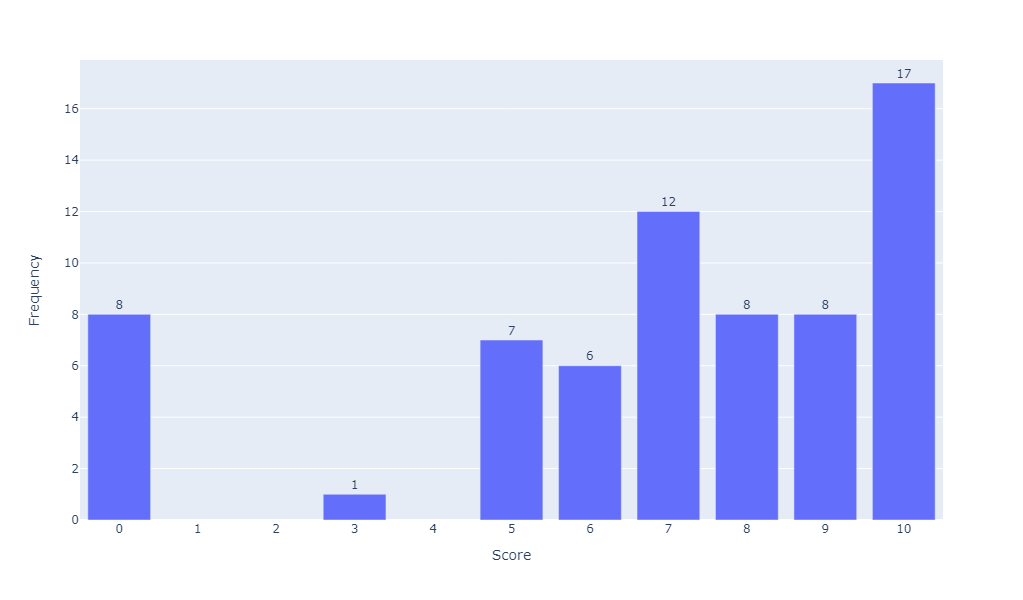

In [121]:
#| label: Q3-responses
Q3 = pd.DataFrame(subset.iloc[:, 2])

value_counts = Q3['How likely are you to recommend OPAL+ to a colleague?'].value_counts().reset_index()
value_counts.columns = ['Score', 'Frequency']
sorted_df = value_counts.sort_values(by='Frequency', ascending=False)
fig = px.bar(sorted_df, x='Score', y='Frequency', title="", text_auto = True)
fig.update_traces(textposition="outside", textangle=0, cliponaxis=False)
fig.update_layout(
    xaxis= dict(
        tickmode = 'linear',
        dtick = 1
    ),
        width=800,  # Width of the plot
        height=600  # Height of the plot
    )
fig.show()


# Q4: Have you used Patient Services on DoS?

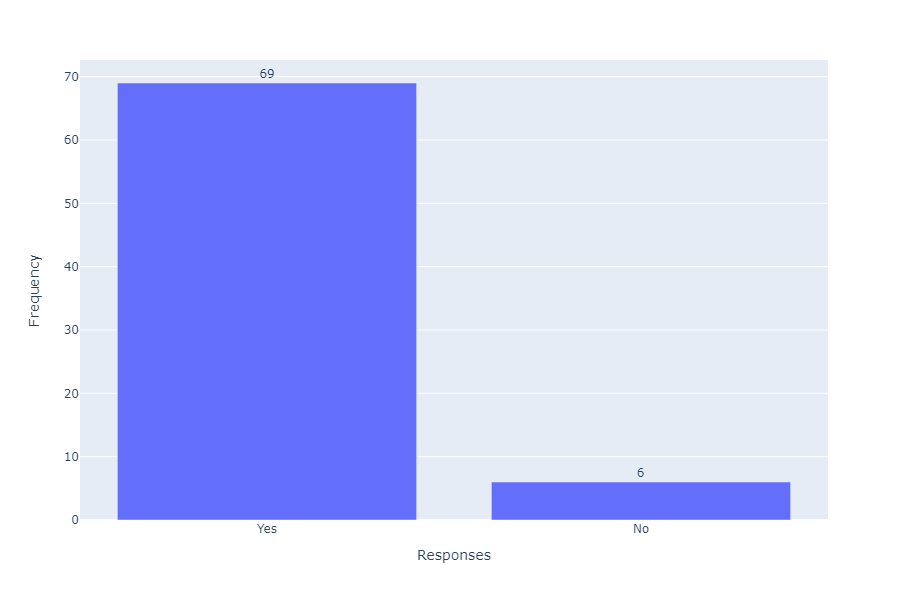

In [123]:
#| label: Q4-responses

Q4 = pd.DataFrame(subset.iloc[:, 3])

value_counts = Q4['Have you used Patient Services on DoS?'].value_counts().reset_index()
value_counts.columns = ['Responses', 'Frequency']
sorted_df = value_counts.sort_values(by='Frequency', ascending=False)
fig = px.bar(sorted_df, x='Responses', y='Frequency', title="", text_auto = True)
fig.update_traces(textposition="outside", textangle=0, cliponaxis=False)
fig.update_layout(
    xaxis= dict(
        tickmode = 'linear',
        dtick = 1
    ),
        width=800,  # Width of the plot
        height=600  # Height of the plot
    )
fig.show()


# Q5: Do Senior Clinicians come out to the Ambulance to discuss your patient when delayed?

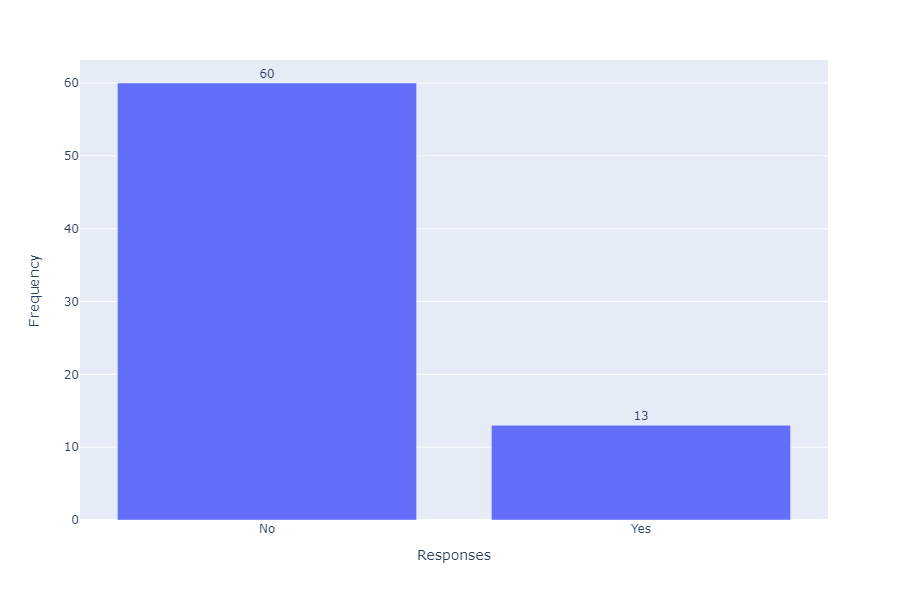

In [125]:
#| label: Q5-responses
Q5 = pd.DataFrame(subset.iloc[:, 4])

value_counts = Q5['Do Senior Clinicians come out to the Ambulance to discuss your patient when delayed?'].value_counts().reset_index()
value_counts.columns = ['Responses', 'Frequency']
sorted_df = value_counts.sort_values(by='Frequency', ascending=False)
fig = px.bar(sorted_df, x='Responses', y='Frequency', title="", text_auto = True)
fig.update_traces(textposition="outside", textangle=0, cliponaxis=False)
fig.update_layout(
    xaxis= dict(
        tickmode = 'linear',
        dtick = 1
    ),
        width=800,  # Width of the plot
        height=600  # Height of the plot
    )
fig.show()


# Q6: Who do you call for Clinical Support on scene?

::: {.panel-tabset}

## Bar chart

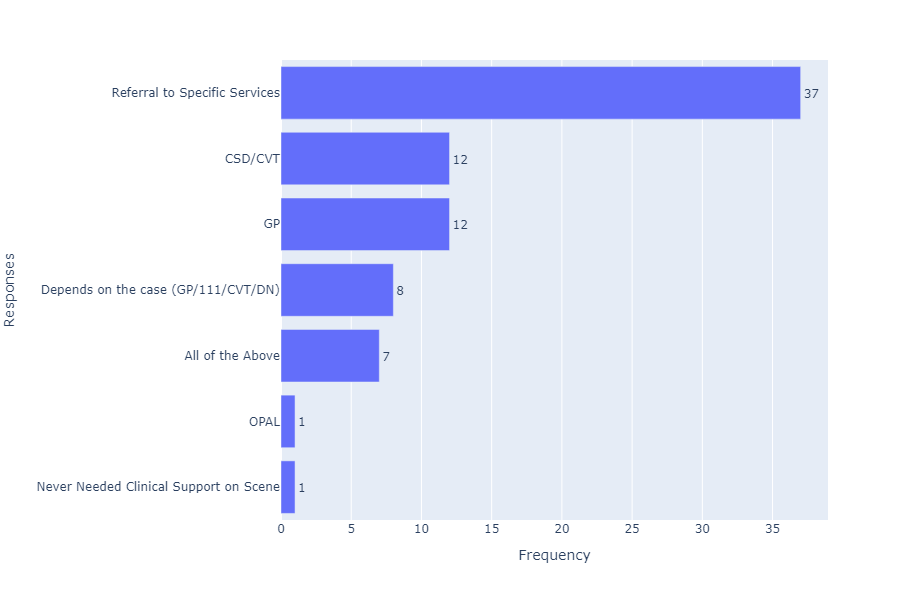

In [129]:
#| label: Q6-responses

Q6_theme = pd.DataFrame(theme.iloc[:, 2].dropna())

plot_bar_chart(Q6_theme, column = 'Q6.Theme', title = "")

## Word Cloud

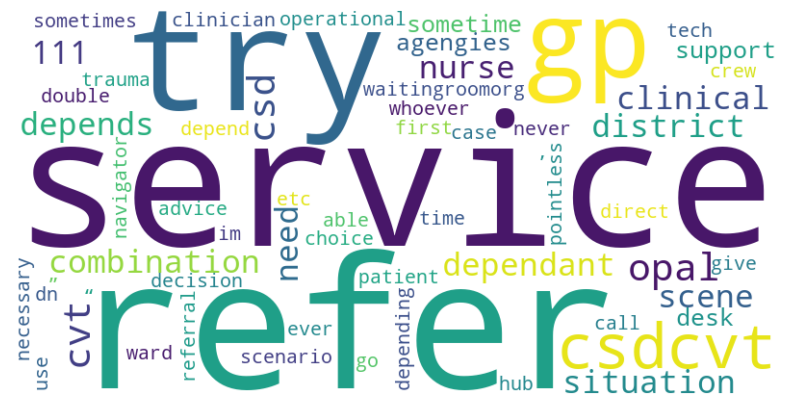

In [130]:

plot_wordcloud(Q6_word_counts)

:::

# Q7: What do you feel would improve handover delays?

::: {.panel-tabset}

## Bar chart

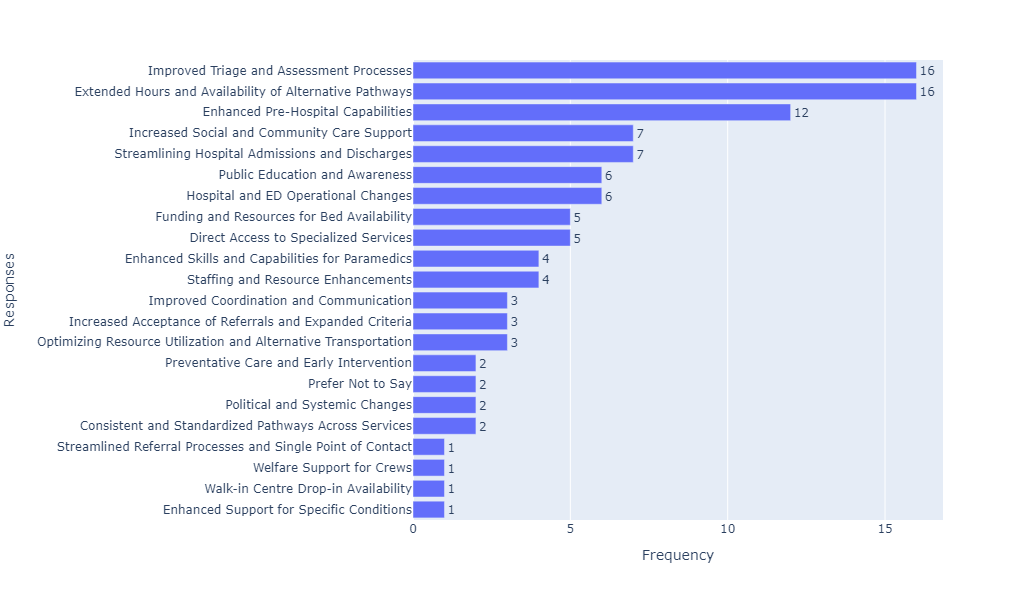

In [131]:
#| label: Q7-responses

Q7_theme = pd.DataFrame(theme.iloc[:, 3].dropna())

plot_bar_chart(Q7_theme, column = 'Q7.Theme', title = "")

## Word Cloud

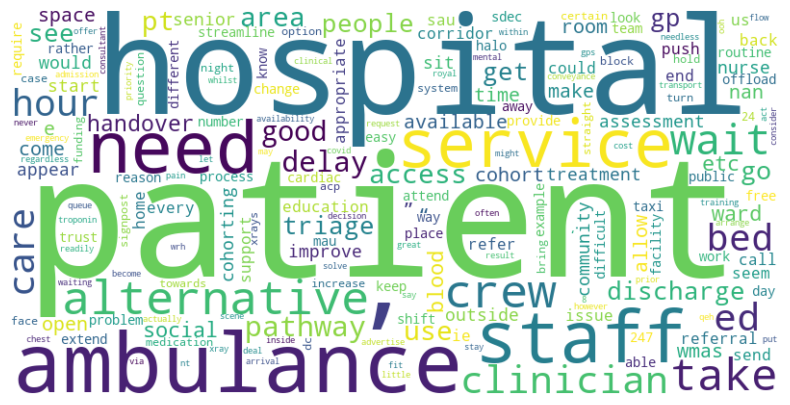

In [132]:
plot_wordcloud(Q7_word_counts)

:::

# Q8: Have you used SDEC Services?

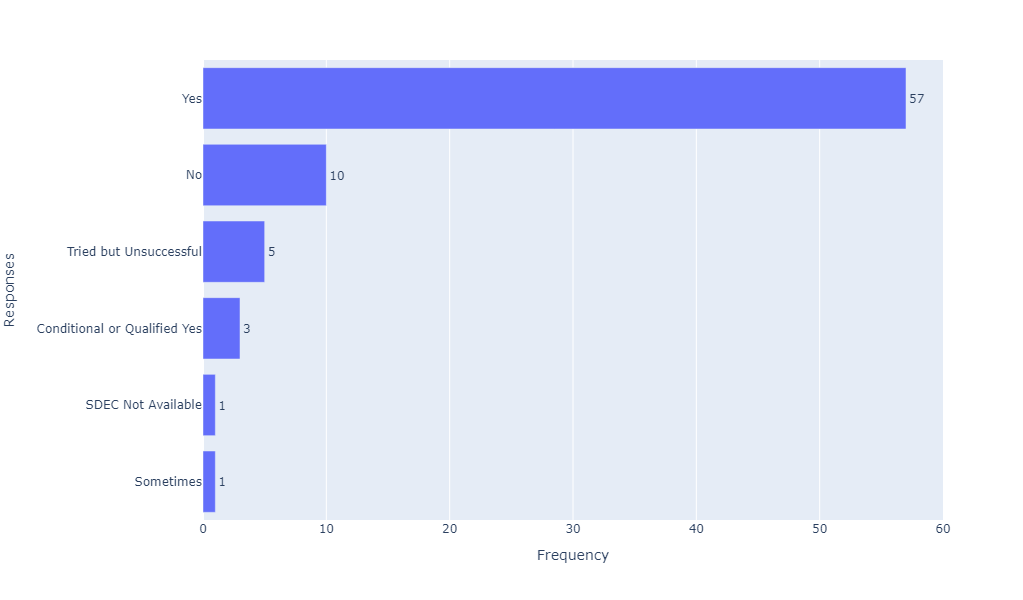

In [136]:
#| label: Q8-responses

Q8_theme = pd.DataFrame(theme.iloc[:, 4].dropna())

plot_bar_chart(Q8_theme, column = 'Q8.Theme', title = "")